# Visualize AURORA 🔎

## Import

In [1]:
import os
from pathlib import Path
import pickle
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
from flax import serialization

from lenia.lenia import ConfigLenia, Lenia
from vae import VAE
from qdax.core.containers.unstructured_repertoire import UnstructuredRepertoire

import matplotlib.pyplot as plt
import mediapy
from IPython.display import display, HTML
from omegaconf import OmegaConf
from analysis.visualize_aurora import plot_aurora_repertoire
from common import get_metric

## Load run

In [2]:
run_dir = Path("/workspace/src/output/aurora/pos_linear_velocity_avg/2024-06-05_224145_296752")

In [3]:
# Get config
config = OmegaConf.load(run_dir / ".hydra" / "config.yaml")

# Init a random key
key = jax.random.PRNGKey(config.seed)

# Lenia
config_lenia = ConfigLenia(
	# Init pattern
	pattern_id=config.pattern_id,

	# Simulation
	world_size=config.world_size,
	world_scale=config.world_scale,
	n_step=config.n_step,

	# Genotype
	n_params_size=config.n_params_size,
	n_cells_size=config.n_cells_size,
)
lenia = Lenia(config_lenia)

# Lenia steps
lenia_step = partial(lenia.step, phenotype_size=config_lenia.world_size, center_phenotype=False, record_phenotype=True)
lenia_step_small = partial(lenia.step, phenotype_size=config.phenotype_size, center_phenotype=True, record_phenotype=True)
lenia_step_medium = partial(lenia.step, phenotype_size=64, center_phenotype=True, record_phenotype=True)
lenia_step_large = partial(lenia.step, phenotype_size=config.world_size, center_phenotype=True, record_phenotype=True)

# Load pattern
init_carry, init_genotype, other_asset = lenia.load_pattern(lenia.pattern)

## Load repertoire

In [4]:
_, reconstruction_fn = ravel_pytree(init_genotype)
repertoire = UnstructuredRepertoire.load(reconstruction_fn=reconstruction_fn, path=str(run_dir) + "/repertoire/")

repertoire = repertoire.replace(observations=jnp.zeros((repertoire.size)))

In [5]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=3, perplexity=5., max_iter=1000)
descriptors_3d = tsne.fit_transform(repertoire.descriptors)

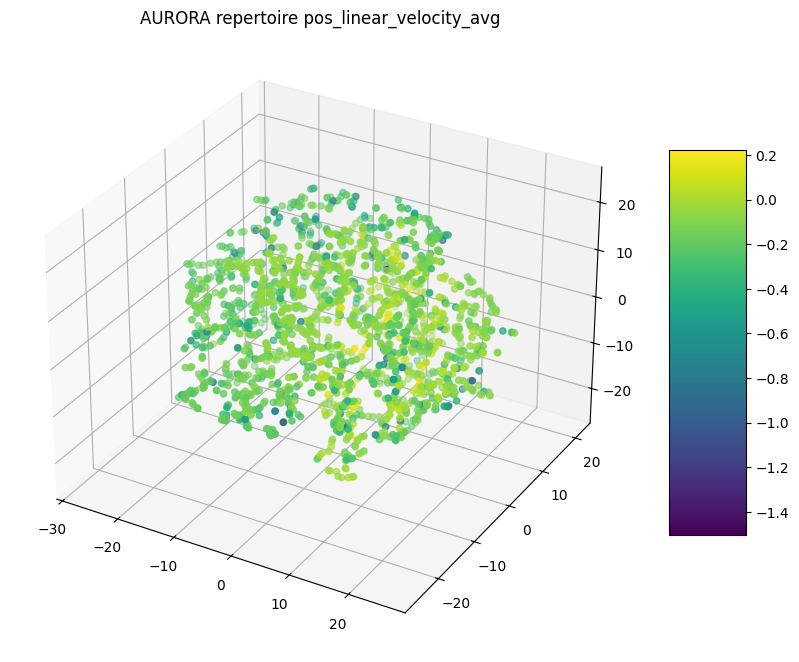

In [6]:
fig, axes = plot_aurora_repertoire(config, repertoire, descriptors_3d)
plt.show()
plt.close()

## Load AE

In [197]:
# Instantiate AURORA
key, subkey_1, subkey_2 = jax.random.split(key, 3)
phenotype_fake = jnp.zeros((config.phenotype_size, config.phenotype_size, lenia.n_channel))
vae = VAE(img_shape=phenotype_fake.shape, latent_size=config.qd.hidden_size, features=config.qd.features)
params = vae.init(subkey_1, phenotype_fake, subkey_2)

with open(run_dir / "params.pickle", "rb") as params_file:
	state_dict = pickle.load(params_file)
params = serialization.from_state_dict(params, state_dict)

## Evaluate

In [198]:
def get_fitness(accum):
	fitness = get_metric(accum, config.qd.fitness, config.qd.n_keep)
	assert fitness.size == 1
	fitness = jnp.squeeze(fitness)
	failed = jnp.logical_or(accum.stats.is_empty.any(), accum.stats.is_full.any())
	failed = jnp.logical_or(failed, accum.stats.is_spread.any())
	fitness = jnp.where(failed, -jnp.inf, fitness)
	return fitness

def evaluate(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_small(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_small, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_medium(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_medium, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_large(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_large, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

## Best Solitons 🏆


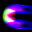
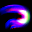
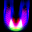
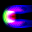
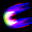
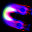
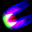
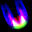
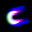
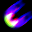
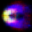
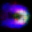
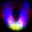
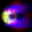
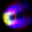
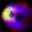
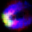
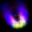
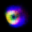
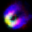

In [227]:
# Select genotypes
genotype_start = 0
indices = jnp.argsort(repertoire.fitnesses)[-1-genotype_start:-1-genotype_start-10:-1]
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_small = jax.vmap(evaluate_small)(genotypes)

# VAE
key, subkey_1, subkey_2 = jax.random.split(key, 3)
latent = vae.apply(params, accum_small.phenotype, subkey_1, method=vae.encode)
phenotype_recon = vae.apply(params, latent, subkey_2, method=vae.generate)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_small.phenotype[:, -1], width=128, height=128, return_html=True)
html += mediapy.show_images(phenotype_recon[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

## Random Solitons 🎲


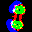
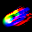
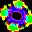
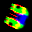
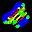
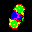
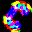
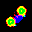
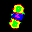
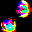
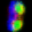
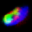
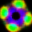
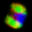
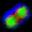
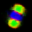
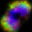
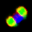
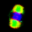
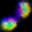

In [213]:
# Select genotypes
num_genotypes = 10
key, subkey = jax.random.split(key)
valid = repertoire.fitnesses != -jnp.inf
indices = jax.random.choice(subkey, jnp.arange(config.qd.repertoire_size), shape=(num_genotypes,), replace=False, p=valid)
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_small = jax.vmap(evaluate_small)(genotypes)

# VAE
key, subkey_1, subkey_2 = jax.random.split(key, 3)
latent = vae.apply(params, accum_small.phenotype, subkey_1, method=vae.encode)
phenotype_recon = vae.apply(params, latent, subkey_2, method=vae.generate)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_small.phenotype[:, -1], width=128, height=128, return_html=True)
html += mediapy.show_images(phenotype_recon[:, -1], width=128, height=128, return_html=True)

display(HTML(html))